In [2]:
import jax3dp3 as j
import os
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
import matplotlib

intrinsics = j.Intrinsics(
    height=150,
    width=150,
    fx=200.0, fy=200.0,
    cx=75.0, cy=75.0,
    near=0.001, far=1.0
)

model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")

renderer = j.Renderer(intrinsics)
model_names = j.ycb_loader.MODEL_NAMES
for IDX in range(len(model_names)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(mesh, scaling_factor=1.0/1000.0)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 1024)


In [3]:
model_names[16]

'037_scissors'

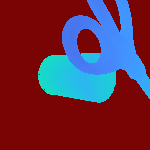

In [4]:
object_pose = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.0, 0.0, 0.3])
    ),
    0.001, 0.1
)

object_pose2 = j.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(2),
    j.t3d.transform_from_pos(
        jnp.array([0.05, 0.0, 0.2])
    ),
    0.001, 0.1
)

GT_ID = 3
observed_depth = renderer.render_multiobject(
    jnp.array([object_pose, object_pose2]),
    [GT_ID, 16]
)[...,2]
noise = jax.random.normal(jax.random.PRNGKey(10), observed_depth.shape) * 0.0
observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
observed_image = j.t3d.unproject_depth_jit(observed_depth + noise, intrinsics)
observed_image_viz = j.get_depth_image(observed_image[:,:,2],max=intrinsics.far)
observed_image_viz

In [5]:
# configure c2f
grid_widths = [0.1, 0.05, 0.03, 0.01, 0.01, 0.01]
rot_angle_widths = [jnp.pi, jnp.pi, jnp.pi, jnp.pi, jnp.pi/5, jnp.pi/5]
sphere_angle_widths = [jnp.pi, jnp.pi/2, jnp.pi/4, jnp.pi/4, jnp.pi/5, jnp.pi/5]
grid_params =  [(3,3,3,75*5,15), (3,3,3,75*3,21),(3,3,3,55,45),(3,3,3,55,45), (3,3,3,45,45), (3,3,3,45,45)]  # (num_x, num_y, num_z, num_fib_sphere, num_planar_angle)

scheds = j.c2f.make_schedules(
    grid_widths=grid_widths, 
    angle_widths=rot_angle_widths, 
    grid_params=grid_params, 
    full_pose=True, 
    sphere_angle_widths=sphere_angle_widths
)


In [6]:
def get_pose_estimate(point_cloud_image, GT_ID, init_pose=None, num_iterations=None):
    if init_pose is None:
        
        center = jnp.mean(point_cloud_image[point_cloud_image[:,:,2]< intrinsics.far],axis=0)
        pose_estimate = j.t3d.transform_from_pos(center)
    else:
        pose_estimate = init_pose
    best_weight = -jnp.inf
    
    if num_iterations is None:
        num_iterations = len(scheds)
    
    for iteration in range(num_iterations):
        deltas = scheds[iteration]
        for batch in jnp.array_split(deltas, deltas.shape[0] // 2000):
            pose_proposals = jnp.einsum('ij,ajk->aik', pose_estimate, batch)

            rendered_depth = renderer.render_parallel(pose_proposals, GT_ID)[...,2]
            rendered_point_cloud_images = j.t3d.unproject_depth_vmap_jit(rendered_depth, intrinsics)

            R_SWEEP = jnp.array([0.01])
            OUTLIER_PROB=0.05
            OUTLIER_VOLUME=100.0
            weights = j.threedp3_likelihood_with_r_parallel_jit(
                point_cloud_image, rendered_point_cloud_images, R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME
            )
            if weights.max() > best_weight:
                pose_estimate = pose_proposals[weights.argmax()]
                best_weight = weights.max()
        print(best_weight)
    return pose_estimate

In [7]:
ID = 9
ID = GT_ID
pose_estimate = get_pose_estimate(observed_image, ID, init_pose=j.t3d.transform_from_pos(object_pose[:3,3]))

48839.555
48841.117
48841.117
48841.117
48842.4
48842.4


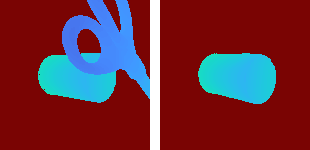

In [8]:
reconstructed_depth = renderer.render_multiobject(
    jnp.array([pose_estimate]),
    [ID]
)[...,2]
# noise = jax.random.normal(jax.random.PRNGKey(10), observed_depth.shape) * 0.001
# observed_depth = observed_depth.at[observed_depth < intrinsics.near].set(intrinsics.far)
rendered_image = j.t3d.unproject_depth_jit(reconstructed_depth, intrinsics)
rendered_image_viz = j.get_depth_image(rendered_image[:,:,2],max=intrinsics.far)
j.hstack_images(
    [
        observed_image_viz,
        rendered_image_viz
    ]
)

In [9]:
def likelihood(obs_xyz, rendered_xyz, r, outlier_prob, outlier_volume):
    num_latent_points = obs_xyz.shape[1] * obs_xyz.shape[0]
    probs = j.gaussian_mixture_image(obs_xyz, rendered_xyz, r)
    probs_with_outlier_model = probs * (1.0 - outlier_prob) / num_latent_points   + outlier_prob / outlier_volume
    return (jnp.log(probs_with_outlier_model)).sum() 

def make_outlier_posterior_graph(x,y):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x, y, label="Matched", color=color)
    plt.fill_between(x, y, color=color, alpha=0.5)
    plt.xlim((-0.05, 0.25))
    plt.ylim((0.0, 1.1))
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4],fontsize=15)
    plt.xlabel("Outlier Probability",fontsize=20)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im

def make_r_posterior_graph(x,y):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x, y, label="Matched", color=color)
    plt.fill_between(x, y, color=color, alpha=0.5)
    plt.xlim((-0.005, 0.11))
    plt.ylim((0.0, 1.1))
    plt.xticks([0.0, 0.025, 0.05, 0.075, 0.1],fontsize=15)
    plt.xlabel("R",fontsize=20)
    plt.yticks([ 0.2, 0.4, 0.6, 0.8, 1.0],fontsize=15)
    plt.ylabel("Probability",fontsize=20)
    plt.tight_layout()
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    return im


likelihood_jit = jax.jit(
    jax.vmap(jax.vmap(likelihood, in_axes=(None, None, None, 0, None)), in_axes=(None, None, 0, None, None))
)

In [10]:
### 

OUTLIER_PROBS = jnp.linspace(0.005, 0.2, 100)
R = jnp.linspace(0.001, 0.05, 200)
OUTLIER_VOLUME = 1000.0
p = likelihood_jit(observed_image, rendered_image, R, OUTLIER_PROBS, OUTLIER_VOLUME)



ii,jj = jnp.unravel_index(p.argmax(), p.shape)
best_r, best_outlier_prob = (R[ii], OUTLIER_PROBS[jj])
print(R[ii], OUTLIER_PROBS[jj])

0.001 0.17636365


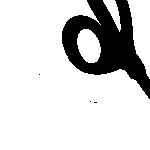

In [11]:
outliers = (
    (j.gaussian_mixture_image(observed_image, rendered_image, best_r) * (1.0 - best_outlier_prob)) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
outlier_viz = j.get_depth_image(outliers, cmap=matplotlib.colormaps['Greys'])
outlier_viz

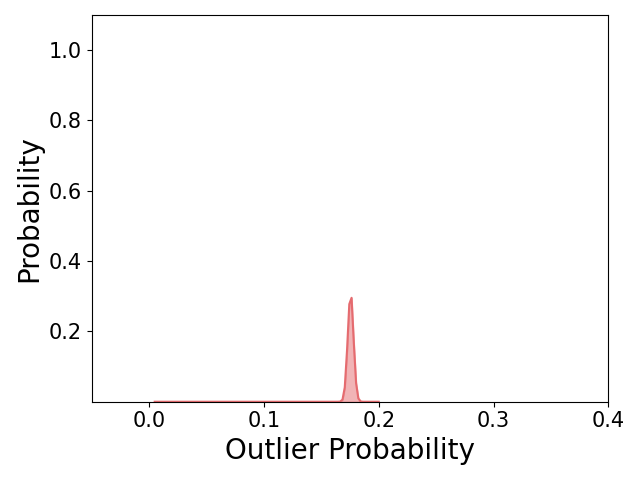

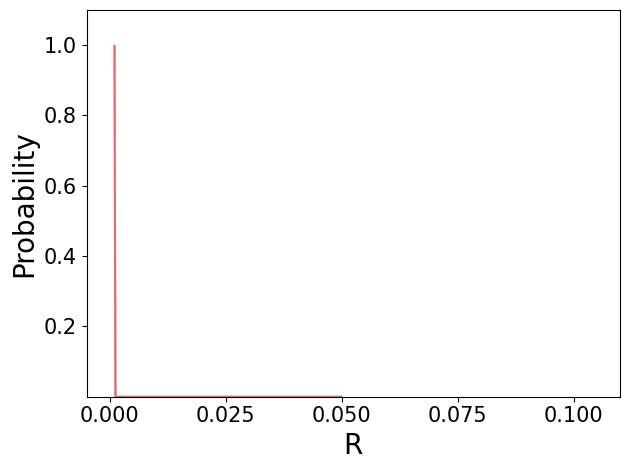

In [12]:
outlier_prob_viz = make_outlier_posterior_graph(OUTLIER_PROBS, j.utils.normalize_log_scores(p).sum(0))
r_viz = make_r_posterior_graph(R, j.utils.normalize_log_scores(p).sum(1))
outlier_prob_viz

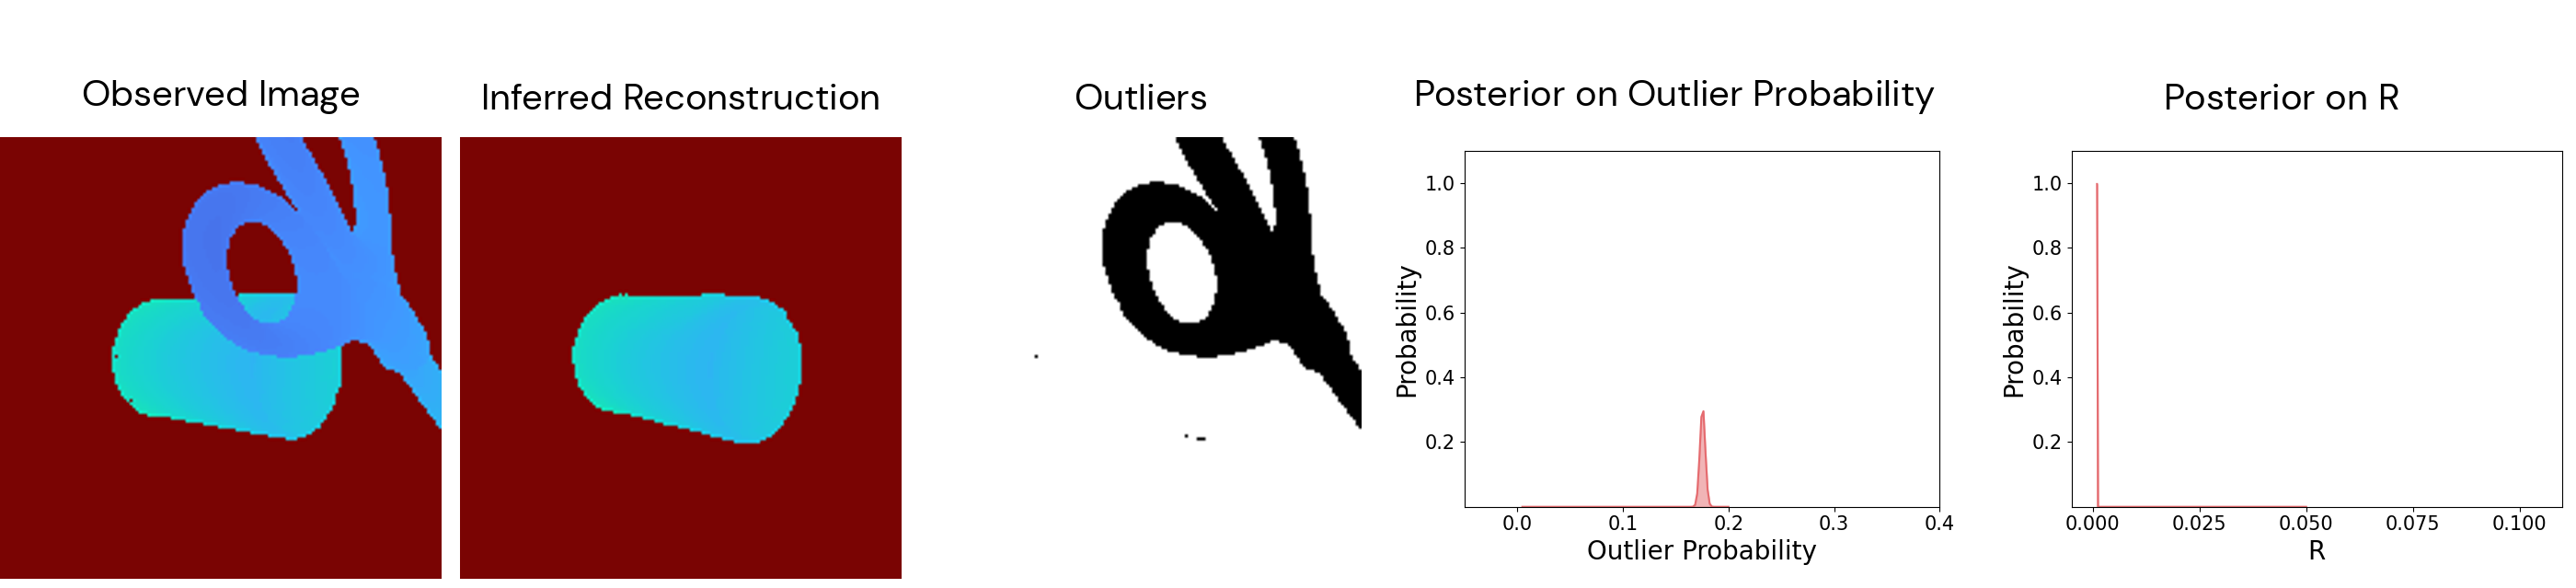

In [13]:
height_factor = outlier_prob_viz.height / observed_image_viz.height
panel = j.multi_panel(
    [
        j.scale_image(observed_image_viz,height_factor),
        j.scale_image(rendered_image_viz,height_factor),
        j.scale_image(outlier_viz,height_factor),
        outlier_prob_viz, r_viz],
    labels=["Observed Image", "Inferred Reconstruction", "Outliers", "Posterior on Outlier Probability", "Posterior on R"],
    label_fontsize=40,
    middle_width = 20
)
panel

/tmp/ipykernel_586595/3628203880.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

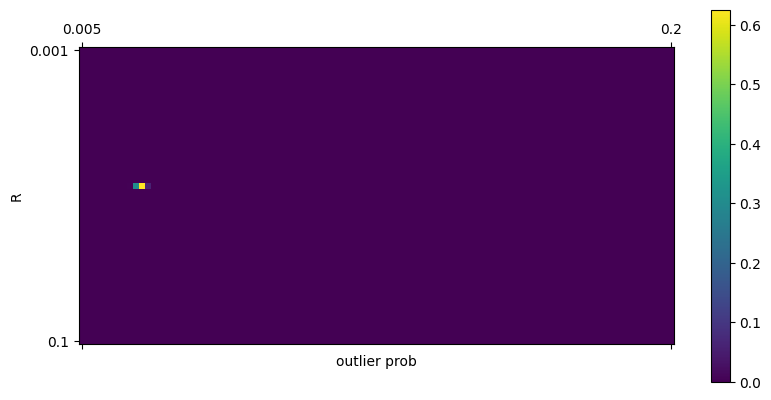

In [211]:
plt.clf()
plt.matshow(j.utils.normalize_log_scores(p))
plt.xlabel("outlier prob")
plt.ylabel("R")
plt.yticks([0,len(R)-1],[str(np.round(R[0].item(),6)), str(np.round(R[-1].item(),6)) ])
plt.xticks([0,len(OUTLIER_PROBS)-1],[str(np.round(OUTLIER_PROBS[0].item(),6)),str(np.round(OUTLIER_PROBS[-1].item(),6))])
# ([str(OUTLIER_PROBS[0].item())] + ['' for _ in range(len(OUTLIER_PROBS)-2)] + [str(OUTLIER_PROBS[-1].item())])
plt.colorbar()
plt.tight_layout()
plt.savefig("1.png")
